In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Barren plateaus in quantum neural networks {#barren_plateaus}
==========================================

::: {.meta}
:property=\"og:description\": Showing how randomized quantum circuits
face the problem of barren plateaus using PennyLane. We will partly
reproduce some of the findings in McClean et. al., 2018 with just a few
lines of code. :property=\"og:image\":
<https://pennylane.ai/qml/_images/surface.png>
:::

::: {.related}
tutorial\_local\_cost\_functions Alleviating barren plateaus with local
cost functions
:::

*Author: Shahnawaz Ahmed (shahnawaz.ahmed95\@gmail.com). Last updated:
26 Oct 2020.*

In classical optimization, it is suggested that saddle points, not local
minima, provide a fundamental impediment to rapid high-dimensional
non-convex optimization (Dauphin et al., 2014).

The problem of such barren plateaus manifests in a different form in
variational quantum circuits, which are at the heart of techniques such
as quantum neural networks or approximate optimization e.g., QAOA
(Quantum Adiabatic Optimization Algorithm) which can be found in this
[PennyLane QAOA
tutorial](https://pennylane.readthedocs.io/en/latest/tutorials/pennylane_run_qaoa_maxcut.html#qaoa-maxcut).

While starting from a parameterized random quantum circuit seems like a
good unbiased choice if we do not know the problem structure, McClean et
al. (2018) show that

*\"for a wide class of reasonable parameterized quantum circuits, the
probability that the gradient along any reasonable direction is non-zero
to some fixed precision is exponentially small as a function of the
number of qubits.\"*

Thus, randomly selected quantum circuits might not be the best option to
choose while implementing variational quantum algorithms.

![](../demonstrations/barren_plateaus/surface.png){.align-center
width="90.0%"}

| 

In this tutorial, we will show how randomized quantum circuits face the
problem of barren plateaus using PennyLane. We will partly reproduce
some of the findings in McClean et. al., 2018 with just a few lines of
code.

::: {.note}
::: {.title}
Note
:::

**An initialization strategy to tackle barren plateaus**

How do we avoid the problem of barren plateaus? In Grant et al. (2019),
the authors present one strategy to tackle the barren plateau problem in
randomized quantum circuits:

*\"The technique involves randomly selecting some of the initial
parameter values, then choosing the remaining values so that the final
circuit is a sequence of shallow unitary blocks that each evaluates to
the identity. Initializing in this way limits the effective depth of the
circuits used to calculate the first parameter update so that they
cannot be stuck in a barren plateau at the start of training.\"*
:::

Exploring the barren plateau problem with PennyLane
---------------------------------------------------

First, we import PennyLane, NumPy, and Matplotlib


In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Next, we create a randomized variational circuit


In [3]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 4          # width of the circuit
dev = qml.device("default.qubit", wires=num_qubits)     # which "device" or simulator
gate_set = [qml.RX, qml.RY, qml.RZ]         # defined for later random choice between them


def rand_circuit(params, random_gate_sequence=None, num_qubits=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    # Initial rotations on all qubits
    for i in range(num_qubits):             # rotate all qubits
        qml.RY(np.pi / 4, wires=i)          # "to prevent X, Y , or Z from being an especially preferential 
                                            # direction with respect to gradients."

    # Single random gate layer (single qubit rotations)
    for i in range(num_qubits):
        random_gate_sequence[i](params[i], wires=i)

    # Nearest neighbour controlled phase gates
    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i + 1])

    # Objective operator H = Z_1 Z_2
    H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    H[0, 0] = 1                                         # why? Does it correspond to the paper?
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H, wirelist))       # How does that work?

Now we can compute the gradient and calculate the variance. While we
only sample 200 random circuits to allow the code to run in a reasonable
amount of time, this can be increased for more accurate results. We only
consider the gradient of the output with respect to the last parameter
in the circuit. Hence we choose to save `gradient[-1]` only.


In [4]:
grad_vals = []
num_samples = 200

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    qcircuit = qml.QNode(rand_circuit, dev)
    grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    grad_vals.append(gradient[-1])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals)
    )
)

Variance of the gradients for 200 random circuits: 0.0056815136930815045
Mean of the gradients for 200 random circuits: -0.001000226897652134


Evaluate the gradient for more qubits
=====================================

We can repeat the above analysis with increasing number of qubits.


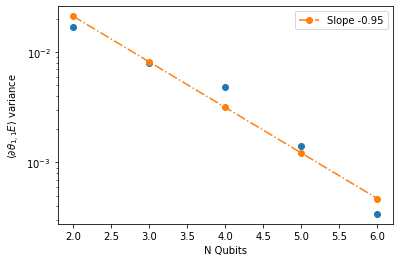

In [9]:
qubits = [2, 3, 4, 5, 6]
variances = []


for num_qubits in qubits:
    grad_vals = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(rand_circuit, dev)
        grad = qml.grad(qcircuit, argnum=0)

        gate_set = [qml.RX, qml.RY, qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}

        params = np.random.uniform(0, np.pi, size=num_qubits)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits
        )
        grad_vals.append(gradient[-1])
    variances.append(np.var(grad_vals))

variances = np.array(variances)
qubits = np.array(qubits)


# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()

References
==========

1.  Dauphin, Yann N., et al., Identifying and attacking the saddle point
    problem in high-dimensional non-convex optimization. Advances in
    Neural Information Processing systems (2014).
2.  McClean, Jarrod R., et al., Barren plateaus in quantum neural
    network training landscapes. Nature communications 9.1 (2018): 4812.
3.  Grant, Edward, et al. An initialization strategy for addressing
    barren plateaus in parametrized quantum circuits. arXiv preprint
    arXiv:1903.05076 (2019).
